# 7.2 构建keras模型的不同方式.ipynb

具体而言是 3 种构建方式

- Sequential model: 最容易上手的方式,脱胎于 python 的 list,基本上只是层的堆叠.
- Functional API: 以类似图的方式构建模型,在易用性和灵活性算是取了一个平衡点.
- Model subclassing: 非常底层的 api,需要自行实现所有,如果你需要控制全部细节,就用这个.代价是许多 keras 内置功能无法使用,自行编码的错误可能会更高.

下图显示了构建 keras 模型复杂性一步一步上升的过程

![progressive_disclosure_of_complexity_models](./progressive_disclosure_of_complexity_models.png)

ps: Functional API 翻译是函数式 api,Model subclassing 翻译应该是 模型子类化,但是下文基本没用中文译名,感觉有点乱.


## Sequential model


In [31]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

这是 mnist 例子中的模型


In [32]:
model = keras.Sequential()
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

上文说到了 Sequential model 是类似 python list 的存在,因此也可以通过 `add` 构建相同的模型.


In [33]:
# model.weights

model 只有在第一次调用时候才真正被初始化,换句话说层的权重只有在第一次调用时才会初始化.上面直接输出权重就错误了.


In [34]:
model.build(input_shape=(None, 3))
print(model.weights)

[<tf.Variable 'dense_13/kernel:0' shape=(3, 64) dtype=float32, numpy=
array([[ 6.06084168e-02, -3.15418839e-03,  8.58865380e-02,
        -1.17399484e-01, -2.18760207e-01,  2.03133106e-01,
         3.94403934e-04,  7.80939758e-02,  2.70989835e-01,
        -2.72370875e-02,  5.91449440e-02,  2.51299858e-01,
         2.65208840e-01,  1.49688691e-01, -2.42584944e-02,
        -1.09088510e-01, -6.49666190e-02,  1.81378871e-01,
         1.68126643e-01, -5.68719655e-02,  1.92425013e-01,
        -2.28488654e-01, -8.10976923e-02,  3.22560370e-02,
         2.58261085e-01, -1.42608956e-01, -2.57614225e-01,
        -1.64356723e-01, -8.17659348e-02, -2.78414786e-02,
         2.89801836e-01,  9.60581005e-02, -7.22503364e-02,
         7.34184384e-02, -2.12388024e-01, -2.29247928e-01,
        -1.78653955e-01,  2.24992812e-01,  1.92946196e-03,
        -1.77435070e-01,  2.77973175e-01, -2.00364202e-01,
        -1.85190320e-01, -1.82224393e-01,  6.55112863e-02,
        -3.31111252e-02,  1.83018506e-01,  1.

`build` 以后,有了输入的规模,weight 才能初始化.


In [35]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 64)                256       
_________________________________________________________________
dense_14 (Dense)             (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


一旦模型初始化后,调用 `model.summary()` 就能输出模型的结构.对调试很方便.


In [36]:
model = keras.Sequential(name="my_example_model")
model.add(layers.Dense(64, activation="relu", name="my_first_layer"))
model.add(layers.Dense(10, activation="softmax", name="my_last_layer"))
model.build((None, 3))
model.summary()

Model: "my_example_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_first_layer (Dense)       (None, 64)                256       
_________________________________________________________________
my_last_layer (Dense)        (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


model 默认名称是 `sequential_1` 每一层是 `dense_2` `dense_3`.
实际上 keras 允许通过 `name` 字段设置 model/layer 名称. just for fun.


In [37]:
model = keras.Sequential()
model.add(layers.InputLayer(input_shape = (3,)))
model.add(layers.Dense(64, activation="relu"))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                256       
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.add(layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                256       
_________________________________________________________________
dense_16 (Dense)             (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


上文无法直接调用 `model.summary()` 是模型还没有初始化,模型不知道输入规模.但是如果提前指定了输入规模,那直接调用 `model.summary()` 就能输出了.

上面这样添加层再 `summary()` 查看,是挺常见的工作流,下一章学习卷积层时会常用.


## Functional API

Sequential 构建模型非常方便,但是通过 Sequential 构建的模型却非常受限,它只能有单一的输入输出,以顺序的形式堆叠.Sequential 无法处理实践中常常会有一次性多个输入(例如: 输入图片和对应的元数据),多个输出(例如: 预测数据多个方面).同时 Sequential 无法构建非线性拓扑模型.

这种情况下就是 Functional API 的天下了,使用 Functional API 构建的模型几乎是最常见的 keras 模型.

想想乐高积木,Functional API 与之类似.


### 单输入单输出模型


In [39]:
inputs = keras.Input(shape=(3,), name="my_input")
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

与上面例子相同的模型,2层,单输入单输出.


In [40]:
inputs = keras.Input(shape=(3,), name="my_input")

In [41]:
inputs.shape

TensorShape([None, 3])

In [42]:
inputs.dtype

tf.float32

从 Input 开始,Input 定义了模型的输入.(Input 也有 name属性).

我们把这边实例称为 符号张量 (symbolic tensor 没找到这个词对应的翻译,暂且如此称呼了),它不包含任何实际的数据,但是代表了将会输入模型的实际张量的规模.


In [43]:
features = layers.Dense(64, activation="relu")(inputs)

In [44]:
features.shape

TensorShape([None, 64])

所有 keras 层都可以调用真实的数据张量或者符号张量,调用符号张量时,keras 层返回的也是符号张量,代表这一层输出的规模.


In [45]:
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_input (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                256       
_________________________________________________________________
dense_20 (Dense)             (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


最后我们定义了模型的输出,调用 `summary` 查看模型的情况.


### 多输入多输出模型

实际上列表堆叠的模型适用范围很小,很多场景下模型的拓扑更像图而不是简单的层叠.构建这样的模型是 Functional API 的强项了.


In [46]:
vocabulary_size = 10000  #文本编码长度
num_tags = 100  # one-hot 编码长度
num_departments = 4  # 部门几个
# 输入数据
title = keras.Input(shape=(vocabulary_size, ), name="title")
text_body = keras.Input(shape=(vocabulary_size, ), name="text_body")
tags = keras.Input(shape=(num_tags, ), name="tags")
# 中间 layer
features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation="relu")(features)
# 输出数据
priority = layers.Dense(1, activation="sigmoid",
                        name="priority")(features)  #优先级
department = layers.Dense(num_departments,
                          activation="softmax",
                          name="department")(features)  #部门

model = keras.Model(inputs=[title, text_body, tags],
                    outputs=[priority, department])

例如上面的模型是按照优先级对客户的票据进行排序,并将其转交给适当部门.

输入

- 票据的标题: 文本
- 票据的正文: 文本
- 用户添加的任何标签: 这里假定是 one-hot 编码

输出

- 票据的优先级: 0~1 sigmoid
- 票据需要转交的部分: 部门的集合 softmax

文本信息编码成了 vocabulary_size 的 01 数组,详情见 11 章.


#### 训练多输入多输出模型


In [47]:
import numpy as np

num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))  #标题
text_body_data = np.random.randint(0, 2,
                                   size=(num_samples, vocabulary_size))  #正文
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))  #标签

priority_data = np.random.random(size=(num_samples, 1))  #优先级
department_data = np.random.randint(0, 2,
                                    size=(num_samples, num_departments))  #部门

model.compile(
    optimizer="adam",  #优化器
    loss=["mean_squared_error", "categorical_crossentropy"],  #损失函数
    metrics=[["mean_absolute_error"], ["accuracy"]])  #指标

model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],
          epochs=1)  #训练模型,传入数据要和 model 声明一致

40/40 [==============================] - 0s 5ms/step - loss: 7.1950 - priority_loss: 0.2069 - department_loss: 6.9880 - priority_mean_absolute_error: 0.3716 - department_accuracy: 0.2305


训练过程和上面的单输入单输出模型一样,只是输入和输出的时组个 `[]` 传入.


In [48]:
results = model.evaluate([title_data, text_body_data, tags_data],
               [priority_data, department_data])#评估模型 传入数据要和 model 声明一致
results

40/40 [==============================] - 0s 4ms/step - loss: 2.9723 - priority_loss: 0.1512 - department_loss: 2.8210 - priority_mean_absolute_error: 0.3196 - department_accuracy: 0.2422


[2.9722564220428467,
 0.15124726295471191,
 2.8210091590881348,
 0.3195568025112152,
 0.2421875]

测试集评估也是一样.


In [49]:
priority_preds, department_preds = model.predict(
    [title_data, text_body_data, tags_data])  # 获取预测值

获取预测值也是一样.


In [50]:
model.compile(
    optimizer="adam",  #优化器
    loss={
        "priority": "mean_squared_error",
        "department": "categorical_crossentropy"
    },  #损失函数
    metrics={
        "priority": ["mean_absolute_error"],
        "department": ["accuracy"]
    })  #指标

model.fit({
    "title": title_data,
    "text_body": text_body_data,
    "tags": tags_data
}, {
    "priority": priority_data,
    "department": department_data
},
          epochs=1)


40/40 [==============================] - 0s 5ms/step - loss: 4.3084 - priority_loss: 0.3315 - department_loss: 3.9768 - priority_mean_absolute_error: 0.4985 - department_accuracy: 0.3367


格式化完成略喜感..

---

如果不想遵守严格的顺序,可以采用类似字典的方式.

定义损失函数等也能用类似字典.


In [51]:
priority_preds, department_preds = model.predict({
    "title": title_data,
    "text_body": text_body_data,
    "tags": tags_data
})


In [52]:
priority_preds, department_preds = model.predict({
    "title": title_data,
    "text_body": text_body_data,
    "tags": tags_data
})

评估和获取预测值类似.

### Functional API 对层的访问

使用 Functional API 一直让我想起乐高积木,Functional 模型是一个明确的图,而在研究人员脑中深度学习模型也是一个非常类似的图.

类似图的结构,让 Functional 模型输出层直接连接,或者重用部分 layer 成为可能.


#### 模型可视化


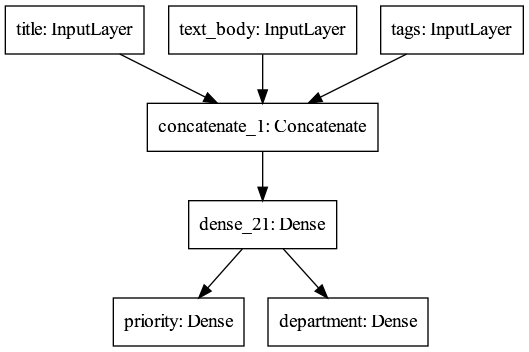

In [53]:
keras.utils.plot_model(model, "ticket_classifier.png")

`keras.utils.plot_model` 可以将 model 以图形的方式展示出来.这非常受用.


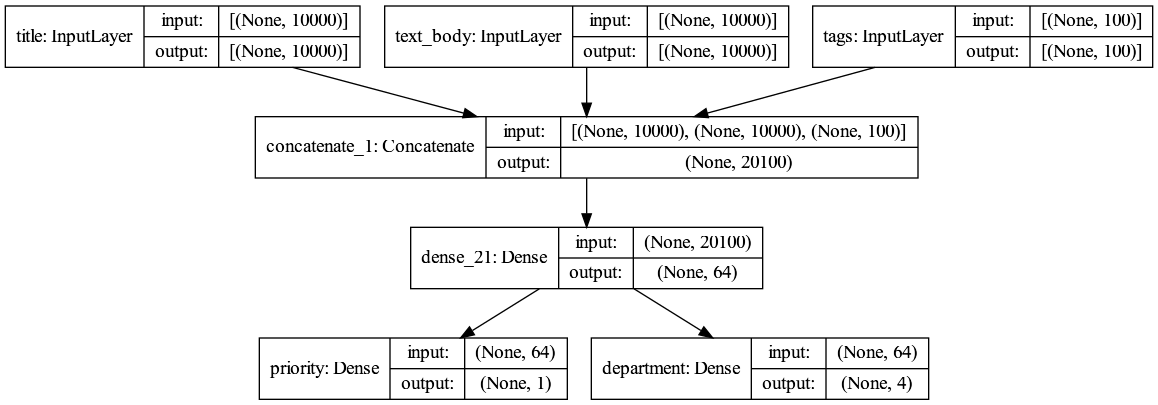

In [54]:
keras.utils.plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes=True)

加上各层的输入输出大小也没关系. None 代表任意大小.


#### 提取模型特征


In [55]:
model.layers

In [56]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

Functional 可以访问所有 layer 包括 layer 对应的 input/output.


In [57]:
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)

new_model = keras.Model(inputs=[title, text_body, tags],
                        outputs=[priority, department, difficulty])

model 每个 layer 声明都是互相独立的,这意味着可以像操作图一样修改模型

- 增删改 model 某个部分
- 重用 model 或部分 model

上面就是在 model 添加一个输出,困难的评级.输出有 3 个级别.


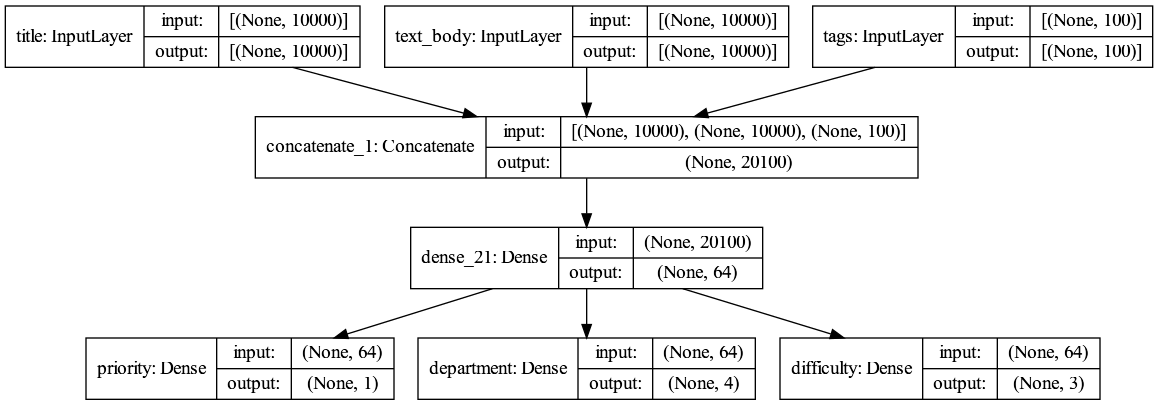

In [58]:
keras.utils.plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)

重新可视化 model 此时困难评级已经添加了.


## model subclassing


最后一种构建模型的方法是 model subclassing.第 3 章,我们已经实现过类似的过程了.继承 Layer 类实现自己的子类.model subclassing 非常类似.

- init 方法中定义要使用的 layer
- 在 call 方法中实现前向传播,重用已经已经创建的层.
- 实例化子类对象,在传入数据时创建权重.


In [59]:
class CustomerTicketModel(keras.Model):
    def __init__(self, num_departments):
        super().__init__()
        self.concat_layer = layers.Concatenate()  #第一层
        self.mixing_layer = layers.Dense(64, activation="relu")  #第二层
        self.priority_scorer = layers.Dense(1, activation="sigmoid")  #优先级
        self.department_classifier = layers.Dense(num_departments,
                                                  activation="softmax")  #部门

    def call(self, inputs):
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]

        features = self.concat_layer([title, text_body, tags])  #第一层
        features = self.mixing_layer(features)  #第二层
        priority = self.priority_scorer(features)  #优先级
        department = self.department_classifier(features)  #部门
        return priority, department

这里重新实现了上面例子里的 model


In [62]:
model = CustomerTicketModel(num_departments=4)  #实例化 model ,部门数 4


In [63]:
priority, department = model({
    "title": title_data,
    "text_body": text_body_data,
    "tags": tags_data
})

只有当第一次调用时,层的权重才会初始化.


与自定义 Layer 子类非常相似,当然也有区别

- Model 子类有 fit evaluate predict 等方法,(废话要不然证明训练评估验证啊)
- Model 子类实例可以保存在硬盘上.


In [66]:
model.compile(optimizer="adam",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit({
    "title": title_data,
    "text_body": text_body_data,
    "tags": tags_data
}, [priority_data, department_data],
          epochs=1)


40/40 [==============================] - 1s 6ms/step - loss: 10.8316 - output_1_loss: 0.3276 - output_2_loss: 10.5040 - output_1_mean_absolute_error: 0.4946 - output_2_accuracy: 0.2812


In [67]:
model.evaluate(
    {
        "title": title_data,
        "text_body": text_body_data,
        "tags": tags_data
    }, [priority_data, department_data])

40/40 [==============================] - 0s 4ms/step - loss: 3.2759 - output_1_loss: 0.3276 - output_2_loss: 2.9483 - output_1_mean_absolute_error: 0.4946 - output_2_accuracy: 0.2937


[3.2758827209472656,
 0.3275989294052124,
 2.9482836723327637,
 0.49458885192871094,
 0.29374998807907104]

In [68]:
priority_preds, department_preds = model.predict({
    "title": title_data,
    "text_body": text_body_data,
    "tags": tags_data
})

模型的训练评估预测,几乎没有什么区别.


Model subclassing 几乎是最灵活的建立模型的方式,如果需要的模型无法表示层有向无环图,那就只能使用  Model subclassing 方式构建模型.

想象一下

- call 方法的 for 循环体中使用 layer
- call 方法中递归调用
- 一切随意.


### model subclassing 无法支持的 keras 部分

model subclassing 异常灵活性的代价是,开发者要负责模型的一切.潜在的出错面太多了.

Functional api 创建的 model 被限定在可以表示成有向无环图,这样我们才能任意的修改/访问/提取 mdoel 的任意部分.

model subclassing 创建的模型其拓扑结构完全取决于代码,完全是一个黑箱,具体的结构能不能可视化都很难说.

- `summary` 将无法显示层的连接
- `plot_model` 也无法绘制
- 对于黑箱,完全得不到任何细节,当然也不能任意的修改/访问/重用 mdoel 的任意部分.
- 同样的一旦实例化,前向传递也成了另一个黑箱..

自由是有代价的(想想早期用 c/c++ 写机器学习的人)
